In [1]:
!pip install stable-baselines[mpi]
!pip install tensorflow==1.15.0
!pip install gym
!pip install stable_baselines3

     |████████████████████████████████| 240 kB 5.1 MB/s 
     |████████████████████████████████| 2.4 MB 38.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.1-cp37-cp37m-linux_x86_64.whl size=2180558 sha256=75d12b2ca6e6337aabe1d8ee20cacefd3da4f10c77ded8ff2c3f71268d1d7b15
  Stored in directory: /root/.cache/pip/wheels/91/be/c0/2b0347be1de5cd8ca9fe67da7ec8c3fe8930fcb6b0df6f2255
Successfully built mpi4py
     |████████████████████████████████| 412.3 MB 11 kB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 503 kB 66.7 MB/s 
     |████████████████████████████████| 3.8 MB 73.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=94cf326aaba424a83ac6893cc4b5f1eb55fad50722decc943894f4ce019f9f50
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558

In [2]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
np.random.seed(99)

import gym
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import stable_baselines
from stable_baselines3 import PPO
print(stable_baselines.__version__)


1.15.0
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

2.10.2


/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
"""
TEST CODE HERE:
"""
t = [i for i in range(1,4)]

print(t)

###

[1, 2, 3]


In [61]:
class BasicEnv(gym.Env):
    
    def __init__(self, numOfPistons, heightOfPiston, actionSpace, timeSteps):

      self.n_pistons = numOfPistons
      self.n_action = actionSpace
      self.height = heightOfPiston
      self.t = timeSteps
      
      self.action_space = gym.spaces.MultiDiscrete( [self.n_action] * self.n_pistons )
      self.observation_space = gym.spaces.MultiDiscrete([self.height] * self.n_pistons)
      self.ball_vector = np.asarray(([1] + [0] * (self.n_pistons - 1))).reshape(1, -1)
      self.states = self.observation_space.sample()
      self.reward = 0

      self.done = False

    def piston_search(self, value, index, action, states):
      temp = index - 2
      for i in range(temp, index + value): # reduced search space by checking neighbouring piston only
        if action[i] == 0:
          if states[i] != 0:
            states[i] -= 1

        elif action[i] == 2:
          if states[i] != self.height:
            states[i] += 1

      return states

    def step(self, action):

      states = np.asarray(self.states)
      index = np.where(self.ball_vector!=0)[0][0]
      theta = 0.3 # user-defined variable

      if (index + 2) != (self.n_pistons) and index == 0:
        states = self.piston_search(3, index + 2, action, states)
      elif (index + 2) != (self.n_pistons) and index == 1:
        states = self.piston_search(3, index + 1, action, states)
      elif (index + 2) != (self.n_pistons) and index > 2:
        states = self.piston_search(3, index, action, states)
      else: 
        states = self.piston_search(2, index, action, states)


      #print(f"Ball Index: {index}")
      if states[index] < states[index + 1]:
        if 0 <= self.ball_vector[index + 1] <= theta:
          if index >= 2:
            if states[index - 1] == states[index - 2] and states[index - 1] < states[index]:
              self.ball_vector = np.zeros(self.n_pistons).astype(float)
              ball_movement = round(np.random.rand(1)[0], 2)
              self.ball_vector[index - 1] = ball_movement
              self.ball_vector[index - 2] = (1 - ball_movement)
              self.reward -= 3
            elif self.ball_vector[index] != 0 and states[index - 1] < states[index]:
              self.ball_vector = np.zeros(self.n_pistons).astype(float)
              self.ball_vector[index] = 1
              self.reward -= 2
            else:
              self.ball_vector = np.zeros(self.n_pistons).astype(float)
              self.ball_vector[index] = 1
              self.reward -= 1
        elif self.ball_vector[index] != 0:
            self.ball_vector = np.zeros(self.n_pistons).astype(float)
            self.ball_vector[index] = 1
            self.reward -= 1

        self.t -= 1
      
      else:
        if self.ball_vector[index] <= theta and states[index] > states[index + 1]:
          self.ball_vector = np.zeros(self.n_pistons).astype(float)
          if index == 0 and states[index + 1] > states[index + 2]:
            self.ball_vector[index + 2] = 1
            self.reward += 2
          elif index + 3 < self.n_pistons:
              if states[index + 2] == states[index + 3]:
                ball_movement = round(np.random.rand(1)[0], 2)
                self.ball_vector[index + 2] = ball_movement
                self.ball_vector[index + 3] = (1 - ball_movement)
                self.reward += 3  

              elif states[index + 1] > states[index + 2]:
                self.ball_vector[index + 2] = 1
                self.reward += 2

              else: 
                self.ball_vector[index + 1] = 1
                self.reward += 1  

          elif index + 2 < self.n_pistons:
              if states[index + 1] == states[index + 2]:
                ball_movement = round(np.random.rand(1)[0], 2)
                self.ball_vector[index + 1] = ball_movement
                self.ball_vector[index + 2] = (1 - ball_movement)
                self.reward += 2  
              elif states[index + 1] > states[index + 2]:
                self.ball_vector[index + 2] = 1
                self.reward += 2  
              else:
                self.ball_vector[index + 1] = 1
                self.reward += 1  
            
          else:
              self.ball_vector[-1] = 1

          self.t -= 1


        elif self.ball_vector[index] == 1:
          self.ball_vector = np.zeros(self.n_pistons).astype(float)
          if index == 0 and states[index] > states[index + 1]:
            self.ball_vector[index + 1] = 1
          elif index + 2 < self.n_pistons and states[index - 1] > states[index] > states[index + 1]:
            if states[index + 1] == states[index + 2]:
              ball_movement = round(np.random.rand(1)[0], 2)
              self.ball_vector[index + 1] = ball_movement
              self.ball_vector[index + 2] = (1 - ball_movement)
      
            else:
              self.ball_vector[index + 1] = 1
            self.reward += 1

          elif states[index] == states[index + 1] and states[index - 1] > states[index]:
            ball_movement = round(np.random.rand(1)[0], 2)
            self.ball_vector[index] = ball_movement
            self.ball_vector[index + 1] = (1 - ball_movement)
            self.reward += 1

          elif states[index - 1] < states[index] > states[index + 1]:
            random_movement = np.random.randint(2, size=1)[0]
            if random_movement == 1:
              self.ball_vector[index + 1] = 1
              self.reward += 1 
            else:
              self.ball_vector[index - 1] = 1
              self.reward -= 1 

          elif states[index - 1] > states[index] > states[index + 1]:
            self.ball_vector[-1] = 1
            self.reward += 1
          else: 
            self.ball_vector[index] = 1
            self.reward -= 1


          self.t -= 1

        elif self.ball_vector[index] > theta:
          temp_v = [self.ball_vector[index], self.ball_vector[index + 1]]
          self.ball_vector = np.zeros(self.n_pistons).astype(float) 
          if index == 0 and states[index] > states[index + 1]:
            self.ball_vector[index + 1] = 1
            self.reward += 1  
          elif index + 2 != self.n_pistons and states[index] > states[index + 1]:
            if states[index + 1] == states[index + 2]:
              ball_movement = round(np.random.rand(1)[0], 2)
              self.ball_vector[index + 1] = ball_movement
              self.ball_vector[index + 2] = (1 - ball_movement)
              self.reward += 1  

            else:
              self.ball_vector[index + 1] = 1
          elif states[index - 1] > states[index] > states[index + 1]:
            self.ball_vector[-1] = 1
            self.reward += 1  
          else:
            self.ball_vector[index], self.ball_vector[index + 1] = temp_v[0], temp_v[1]
            self.reward -= 1

          self.t -= 1
          
        else:
          self.t -= 1
          self.reward -= 1  



      #print(f"Env: {states}")
      if self.ball_vector[-1] == 1 or self.t == 0:
        self.done = True

      info = {}
      return self.ball_vector, self.reward, self.done, info

    def reset(self):
      self.ball_vector = np.asarray(([1] + [0] * (self.n_pistons - 1)))
      #self.observation_space = gym.spaces.MultiDiscrete([self.height] * self.n_pistons)
      return self.ball_vector


    




In [ ]:
from stable_baselines.common.env_checker import check_env
n_steps = 1000
n_pistons = 20
n_height = 5
n_action = 3
env = BasicEnv(n_pistons, n_height, n_action, n_steps)
check_env(env)

In [80]:
from stable_baselines import PPO2
steps = 1000
t = 10000
episodes = 300
seed = 99
pistons_n = 20

env = BasicEnv(pistons_n, 5, 3, 1000)

model = PPO2("MlpPolicy", env, verbose=1, n_steps=steps, seed=99,tensorboard_log="/content/drive/My Drive/FYP/Logs/")
model.learn(total_timesteps=t)


Wrapping the env in a DummyVecEnv.
-------------------------------------
| approxkl           | 0.002458687  |
| clipfrac           | 0.0255       |
| explained_variance | 0.000121     |
| fps                | 303          |
| n_updates          | 1            |
| policy_entropy     | 21.969793    |
| policy_loss        | -0.009642761 |
| serial_timesteps   | 1000         |
| time_elapsed       | 5.41e-05     |
| total_timesteps    | 1000         |
| value_loss         | 2766372.2    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0029083942  |
| clipfrac           | 0.02725       |
| explained_variance | 5.96e-08      |
| fps                | 742           |
| n_updates          | 2             |
| policy_entropy     | 21.951082     |
| policy_loss        | -0.0035378302 |
| serial_timesteps   | 2000          |
| time_elapsed       | 3.33          |
| total_timesteps    | 2000          |
| value_loss         | 82120.23      |
---

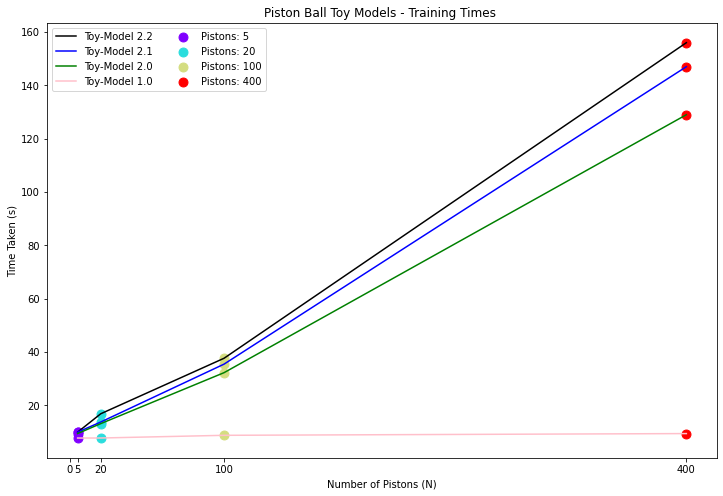

In [74]:
pistons = [5, 20, 100, 400]

time_elapsed_22 = [10, 16.9, 37.7, 156] # checking neighbour pistons only
time_elapsed_opt_21 = [10, 13.8, 35.5, 147]
time_elapsed_opt_20 = [9.48, 13.2, 32.3, 129]
time_elapsed_opt_10 = [7.8, 7.81, 8.82, 9.47]

colors = cm.rainbow(np.linspace(0, 1, len(pistons)))
fig, ax = plt.subplots(1, figsize=(12, 8))

ax.plot([t for t in pistons], time_elapsed_22, color="black", label="Toy-Model 2.2")
ax.plot([t for t in pistons], time_elapsed_opt_21, color="blue", label="Toy-Model 2.1")
ax.plot([t for t in pistons], time_elapsed_opt_20, color="green", label="Toy-Model 2.0")
ax.plot([t for t in pistons], time_elapsed_opt_10, color="pink", label="Toy-Model 1.0")

for t in range(len(pistons)):
    ax.scatter(pistons[t], time_elapsed_22[t], color=colors[t], label=f"Pistons: {pistons[t]}", s=80)
    ax.scatter(pistons[t], time_elapsed_opt_21[t],color=colors[t], s=80)
    ax.scatter(pistons[t], time_elapsed_opt_20[t], color=colors[t], s=80)
    ax.scatter(pistons[t], time_elapsed_opt_10[t], color=colors[t], s=80)
  

plt.title("Piston Ball Toy Models - Training Times ")
ax.set_xlabel("Number of Pistons (N)")
ax.set_ylabel("Time Taken (s)")
ax.set_xticks([0] + pistons)
ax.legend()
ax.legend(loc="upper left", ncol=2)


In [ ]:
!tensorboard --logdir /content/drive/My_Drive/FYP/Logs/PPO_2/ --host localhost --port 6006

In [81]:
model.save("/content/drive/My Drive/FYP/Policies/Piston_Ball_2.2")

In [82]:
model = PPO2.load("/content/drive/My Drive/FYP/Policies/Piston_Ball_2.2")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [83]:
n_steps = 1000
n_pistons = 20
n_height = 5
n_action = 3
n_episodes = 5

reward_lst = np.zeros( (n_episodes, n_steps) )
#current_env = []
for i in range(n_episodes):

  env = BasicEnv(n_pistons, n_height, n_action, n_steps)
  obs = env.reset()
  for step in range(n_steps):

      action, _ = model.predict(obs, deterministic = False)
      print(f"Step: {step + 1}\nAction: {action}")

      obs, reward, done, info = env.step(action)
      print(f"Ball Location: {obs}\nReward: {reward}\n\n")

      reward_lst[i, step] = reward
      #current_env.append(new_env.tolist())
      
      if np.argmax(obs) + 1 == n_pistons and done == True:
        print("Goal Achieved")
        break
        
      if done:
        print("Max Steps Reached")
        break    


Streaming output truncated to the last 5000 lines.
Step: 697
Action: [1 2 1 1 0 2 2 1 1 1 0 1 1 1 2 1 1 1 0 1]
Ball Location: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.26 0.74 0.   0.   0.  ]
Reward: -616


Step: 698
Action: [2 0 2 0 0 1 2 1 1 1 1 0 1 0 2 1 1 1 2 0]
Ball Location: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.26 0.74 0.   0.   0.  ]
Reward: -617


Step: 699
Action: [2 0 2 2 0 0 1 2 0 1 2 0 2 2 2 0 1 0 0 0]
Ball Location: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.26 0.74 0.   0.   0.  ]
Reward: -618


Step: 700
Action: [0 1 0 2 2 1 2 1 2 0 2 0 0 2 1 1 0 2 1 1]
Ball Location: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.26 0.74 0.   0.   0.  ]
Reward: -619


Step: 701
Action: [2 0 0 2 2 2 1 0 2 0 2 0 0 2 0 2 0 0 0 1]
Ball Location: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Reward: -618


Step: 702
Action: [2 0 2 0 2 0 2 

In [16]:
env_states = np.asarray(current_env)
env_states

array([[4, 2, 0, ..., 3, 4, 2],
       [3, 0, 0, ..., 3, 4, 5],
       [4, 2, 0, ..., 3, 4, 2],
       ...,
       [4, 2, 0, ..., 3, 4, 2],
       [4, 2, 0, ..., 3, 4, 2],
       [4, 2, 0, ..., 3, 4, 2]])

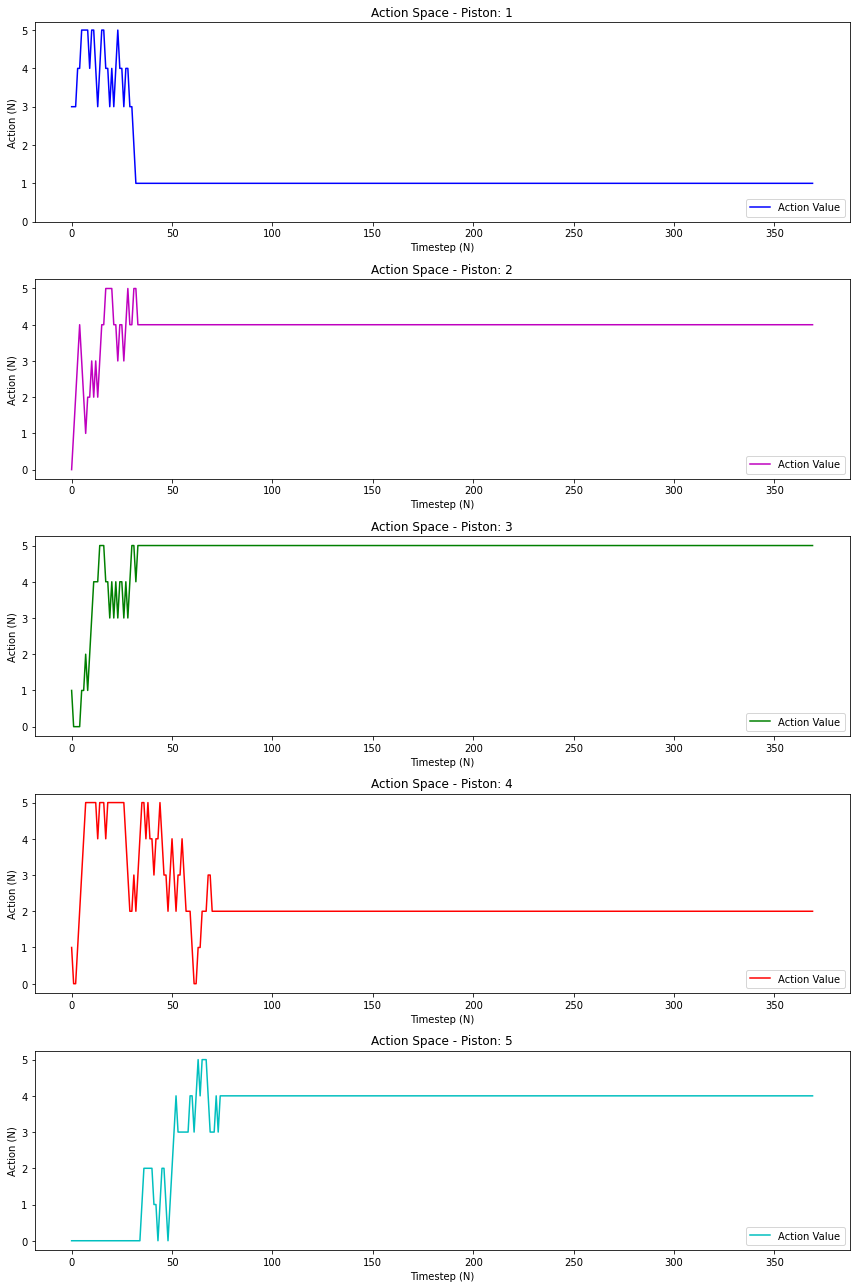

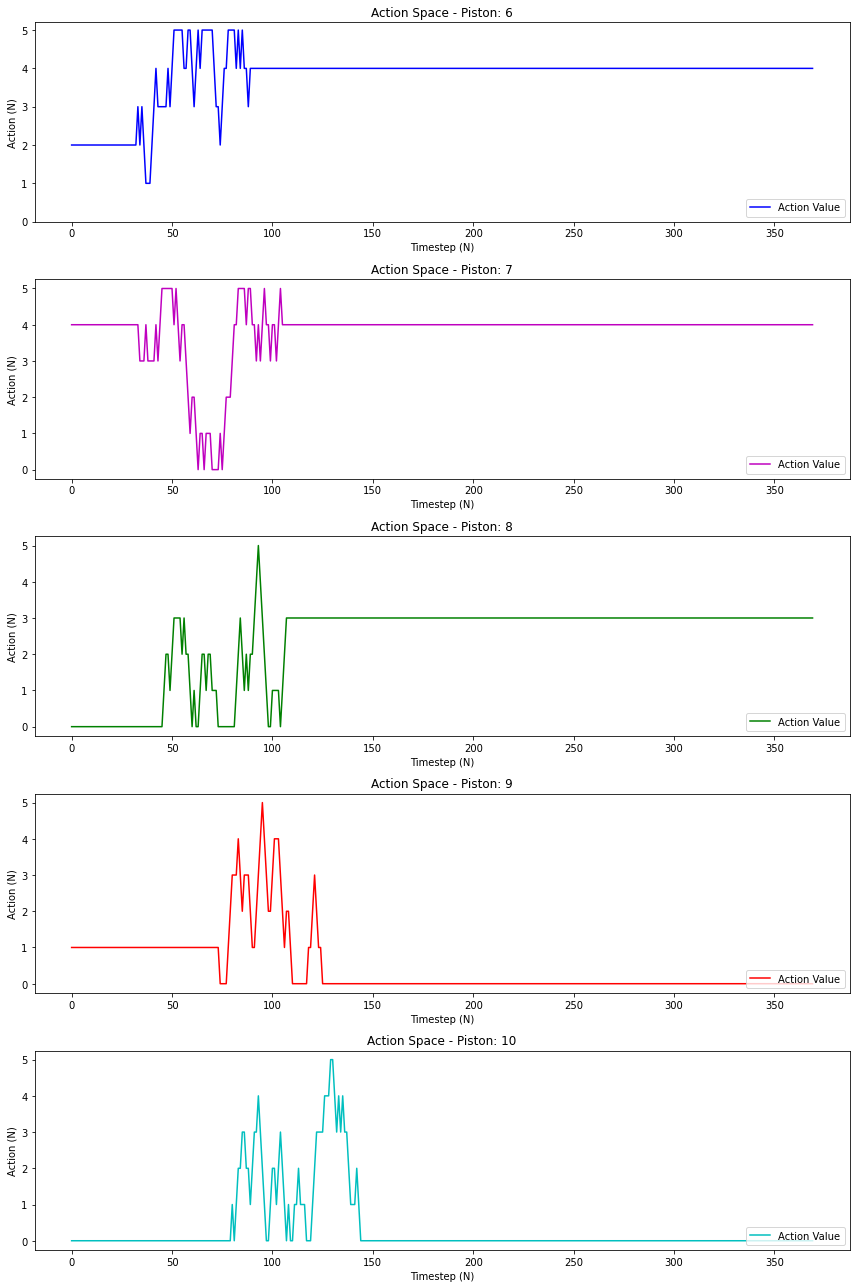

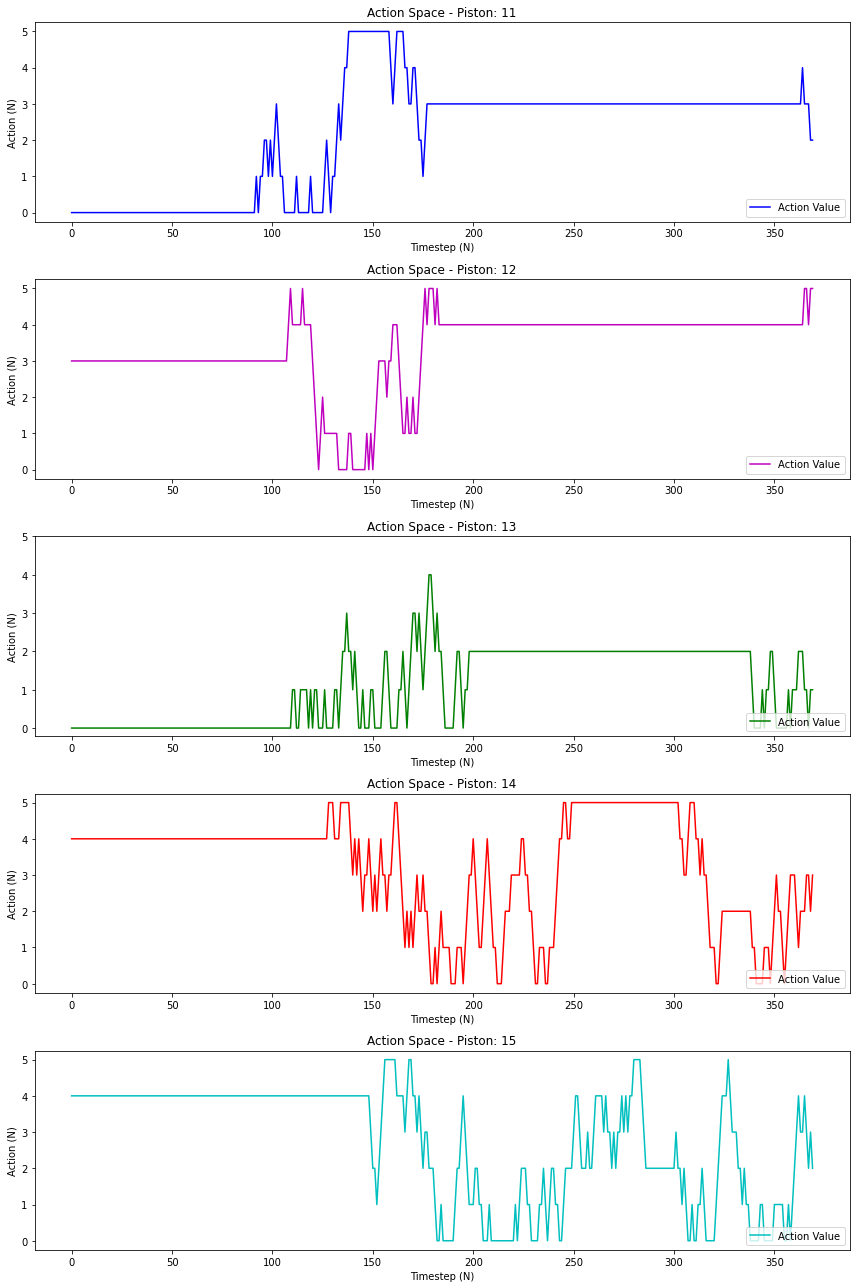

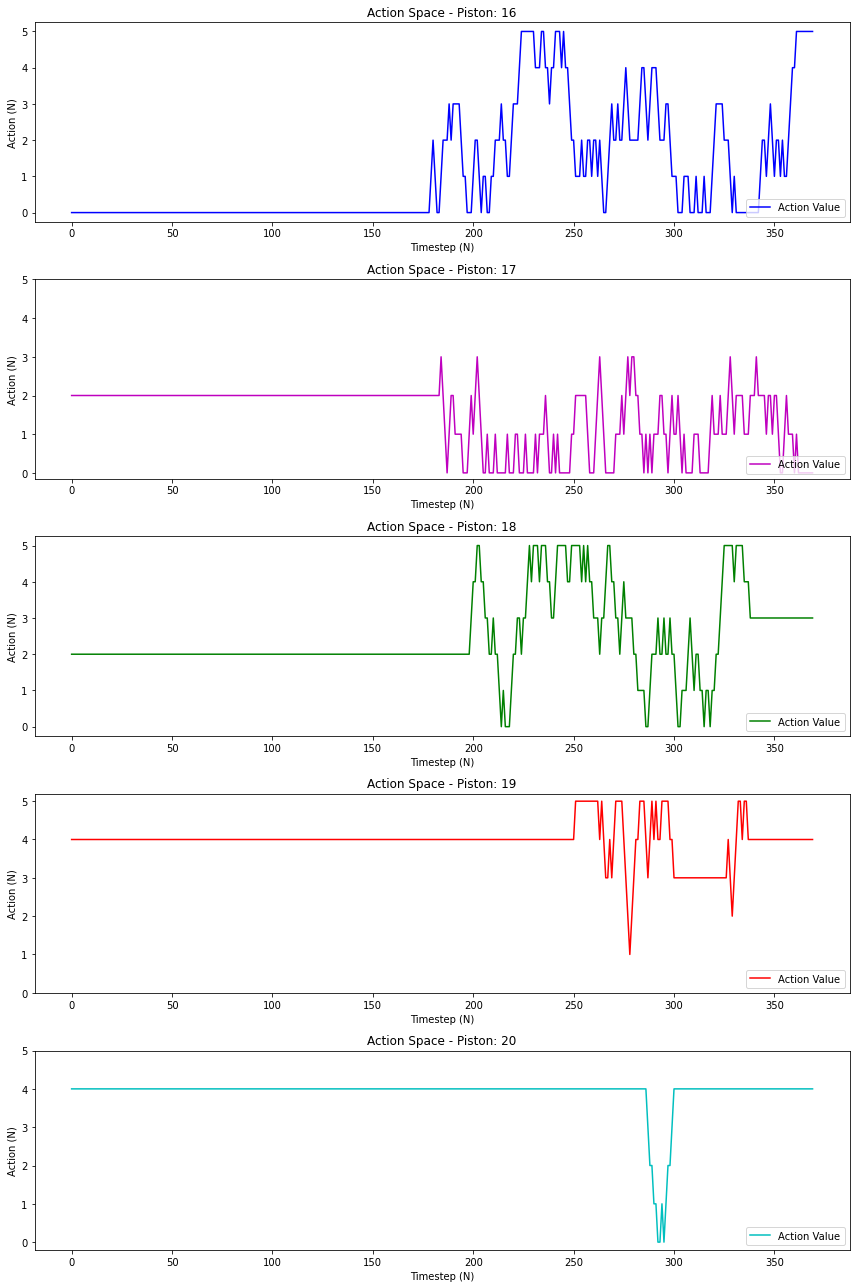

In [66]:
env_states = np.asarray(current_env)
colours = ["b", "m", "g", "r","c"]

for i in range(0, 20, 5):
  counter = 0
  fig, ax = plt.subplots(5, 1, figsize=(12, 18))

  for ii in range(i, i + 5):

    ax[counter].plot(env_states[:, ii],color=colours[counter])
    ax[counter].legend(["Action Value"], loc = "lower right")

    ax[counter].set_title(f"Action Space - Piston: {ii + 1}")
    ax[counter].set_xlabel("Timestep (N)")
    ax[counter].set_ylabel("Action (N)")
    ax[counter].set_yticks([0, 1, 2, 3, 4, 5])

    counter += 1

  fig.tight_layout()

In [85]:
np.set_printoptions(suppress=True)

print(f"Number of Pistons: {n_pistons}\n\n")
averages = np.zeros( (n_episodes, 3) )
for i in range(reward_lst.shape[0]):
  non_zero_array = np.trim_zeros(reward_lst[i,:])
  mean_of_array = np.mean(non_zero_array)
  sum_of_array = np.sum(non_zero_array)
  num_of_timesteps = len(non_zero_array)
  print(f"Episode {i + 1}\nMean: {mean_of_array}\nSum: {sum_of_array}\nTimesteps: {num_of_timesteps}\n")
  averages[i, :] = mean_of_array, sum_of_array, num_of_timesteps
print(f"\nEpisode Mean Values: {np.mean(averages, axis=0)}")

Number of Pistons: 20


Episode 1
Mean: -121.28832116788321
Sum: -33233.0
Timesteps: 274

Episode 2
Mean: -288.36702954898914
Sum: -185420.0
Timesteps: 643

Episode 3
Mean: -405.2885032537961
Sum: -373676.0
Timesteps: 922

Episode 4
Mean: -333.3904639175258
Sum: -258711.0
Timesteps: 776

Episode 5
Mean: -356.6234482758621
Sum: -258552.0
Timesteps: 725


Episode Mean Values: [   -300.99155323 -221918.4            668.        ]


Last Reward: -227.0 for Episode 1
Last Reward: -581.0 for Episode 2
Last Reward: -830.0 for Episode 3
Last Reward: -706.0 for Episode 4
Last Reward: -697.0 for Episode 5


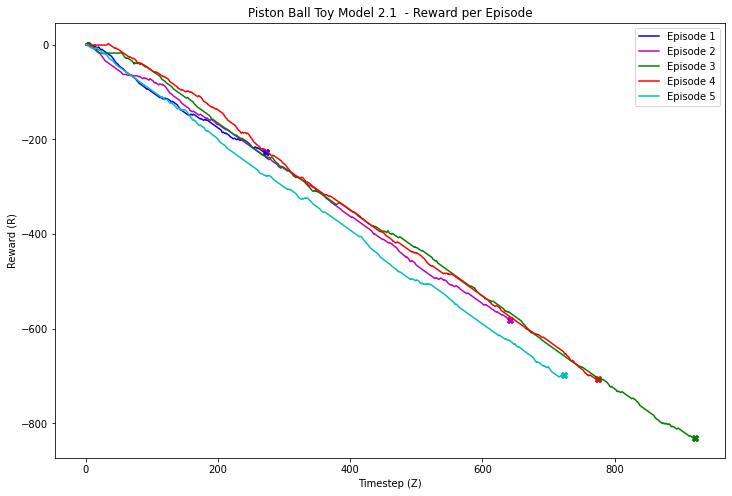

In [84]:
fig, ax = plt.subplots(1, figsize=(12, 8))
colours = ["b", "m", "g", "r", "c"]

for i in range(reward_lst.shape[0]):
  test = np.trim_zeros(reward_lst[i, :])
  plt.title("Piston Ball Toy Model 2.1  - Reward per Episode")
  ax.plot(test,color=colours[i])
  ax.scatter(len(test)-1, test[-1], marker='X',color=colours[i],s=40)
  ax.legend([f"Episode {i+1}" for i in range(reward_lst.shape[0])])
  ax.set_xlabel("Timestep (Z)")
  ax.set_ylabel("Reward (R)")

  print(f"Last Reward: {test[-1]} for Episode {i + 1}")